In [34]:
import sys
from datetime import datetime
import os
from pathlib import Path
sys.path.append(
    os.path.dirname(os.path.abspath('.'))
)
from src import QNet, agent_metrics, show_reward
### path load

import numpy as np
import torch
from torchvision import datasets
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from shift_funcs import get_funcs, FUNCS_INVERT, ACTIONS_INVERT, FUNCS_IRREV, ACTIONS_IRREV
import shift_funcs

SEED = 0
device = 'cuda:0'

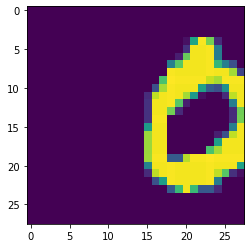

action 1 0.20449491561330413
action 2 0.23639279241108205
action 3 0.016207934154053777
action 4 0.22118055065163322
2


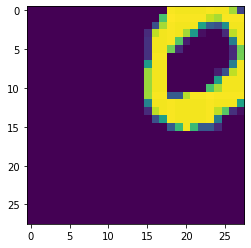

In [3]:
# 右にシフトさせたデータは左にシフトする場合が一番良い結果を返すかを確かめたかった。
# WARNING: しかし、これは可逆シフトの場合は問題である。
#          「４回」で一番MSEが小さくなるという制限をつけているため、3回で右にさらにシフトさせた方がより早くMSEが下がる場合を確かめられていなかった。
# test
tst_data = np.load('data/ur2/test_dataset.npz')
Dx = tst_data['original_dataset']
Dy = tst_data['test_dataset']
fi_N = tst_data['test_func_labels']
actions = [lambda x: x] + ACTIONS_IRREV
n = 3
x, y = Dx[n], Dy[n]
y_init = y.copy()

plt.imshow(y_init)
plt.show()
mse = []
for i in range(4):
    o = y_init.copy()
    for _ in range(4):
        o = actions[i + 1](o)
    m = np.mean((o - x)**2)
    mse.append(m)
    print('action', i + 1, m)
a = np.argmin(mse)
print(a)
o = y_init.copy()
for _ in range(4):
    o = actions[a](o)
plt.imshow(o)
plt.show()

In [5]:
# 4回でMSEが最小のものは、自分が想定している対(上(0)で変換すれば下(1), 右(3)で変換すれば左(2))と同じかを確認した。
# しかし、これも上のセルと同様に「４回」逆変換を施す場合でのMSE最小の行動しか調べていないので、正しい確認になっていない。
# 実際,右(3)の変換に対しては、もう一度右(3)を3回適応した方がより早くMSEが0になる。
err = 0
N = fi_N.shape[0]
for n in range(N):
    fi = fi_N[n]
    expected_a_t = 1 if fi == 0 else 2
    x, y = Dx[n], Dy[n]
    y_init = y.copy()
    mse = []
    for a in range(1, 5):
        o = y_init.copy()
        for _ in range(4):
            o = actions[a](o)
        mse.append(np.mean((o - x)**2))
    a_t = np.argmin(mse)
    if a_t != expected_a_t:
        err += 1
err / N

0.0

In [28]:
# ランダムな場合とMSEを比較
# 可逆でのMSE
outdir = 'udlr8_invert_T16'
FUNCS = FUNCS_INVERT
ACTIONS = ACTIONS_INVERT

RESULT_PATH = Path('results/%s' % outdir)
# データ2種類
for data_dir in tqdm(['udlr8_invert', 'udlr8_diag']):
    mse_random_means = []
    # さらに10種類
    data_prefix = data_dir.split('_')[-1]
    for i in tqdm(range(1, 11), leave=True):
        # load test data
        TEST_DATASET_PATH = f'data/%s/{data_prefix}{i}_dataset.npz' % data_dir
        print("TEST_DATASET_PATH", TEST_DATASET_PATH)
        test_dataset_context = np.load(TEST_DATASET_PATH)
        Dx = test_dataset_context['original_dataset']
        Dy = test_dataset_context['test_dataset']
        labels = test_dataset_context['test_func_labels']
        Dx = torch.from_numpy(Dx)
        Dy = torch.from_numpy(Dy)
        # それぞれのデータセットに対し 10 回測定
        for itr in range(10):
            np.random.seed(itr)
            an_N = np.random.choice(len(actions), (Dy.shape[0], 5))
            mse_random = []
            for n in range(Dy.shape[0]):
                an = an_N[n]
                xn = Dx[n]
                yn = Dy[n].clone()
                for a in an:
                    yn = actions[a](yn)
                mse_random.append(
                    torch.mean((yn - xn)**2).item()
                )
            mse_random = np.array(mse_random)
            mse_random_means.append(mse_random.mean())
    mse_random_means = np.array(mse_random_means)
    print('random mse mean = ', mse_random_means.mean(), 'std', mse_random_means.std())
    np.save(str(RESULT_PATH / 'random' / data_prefix / f'mse{i}_over10samples.npy'), mse_random_means)

TEST_DATASET_PATH data/udlr8_invert/invert1_dataset.npz
TEST_DATASET_PATH data/udlr8_invert/invert2_dataset.npz
TEST_DATASET_PATH data/udlr8_invert/invert3_dataset.npz
TEST_DATASET_PATH data/udlr8_invert/invert4_dataset.npz
TEST_DATASET_PATH data/udlr8_invert/invert5_dataset.npz
TEST_DATASET_PATH data/udlr8_invert/invert6_dataset.npz
TEST_DATASET_PATH data/udlr8_invert/invert7_dataset.npz
TEST_DATASET_PATH data/udlr8_invert/invert8_dataset.npz
TEST_DATASET_PATH data/udlr8_invert/invert9_dataset.npz
TEST_DATASET_PATH data/udlr8_invert/invert10_dataset.npz

random mse mean =  0.17972841128879 std 0.00029186662377422195


TEST_DATASET_PATH data/udlr8_diag/diag1_dataset.npz
TEST_DATASET_PATH data/udlr8_diag/diag2_dataset.npz
TEST_DATASET_PATH data/udlr8_diag/diag3_dataset.npz
TEST_DATASET_PATH data/udlr8_diag/diag4_dataset.npz
TEST_DATASET_PATH data/udlr8_diag/diag5_dataset.npz
TEST_DATASET_PATH data/udlr8_diag/diag6_dataset.npz
TEST_DATASET_PATH data/udlr8_diag/diag7_dataset.npz
TEST_DATASET_PATH data/udlr8_diag/diag8_dataset.npz
TEST_DATASET_PATH data/udlr8_diag/diag9_dataset.npz
TEST_DATASET_PATH data/udlr8_diag/diag10_dataset.npz

random mse mean =  0.1897508186092084 std 0.0002854040682058268



In [ ]:
### INVERTデータセットと対角データセットをランダムに復元した場合のMSEを測定しておく

2 channel weight: =  0.05
RESULT_PATH results/udlr8_invert_T16/channel02_weight005_seed00


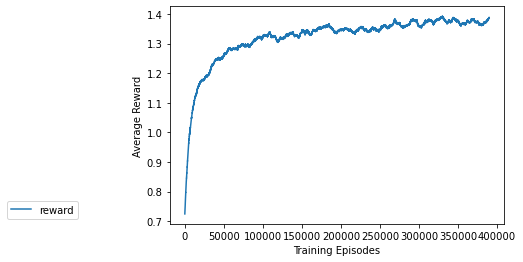

TEST_DATASET_PATH data/udlr8_diag/test_dataset.npz
{0, 1, 2, 3, 4, 5, 6, 7}
0.19132275394080483
MODEL_PATH results/udlr8_invert_T16/channel02_weight005_seed00/Qnet020000.pth
MSE(test_dataset, agent_outputs) =  0.042769728048780195
--------------------



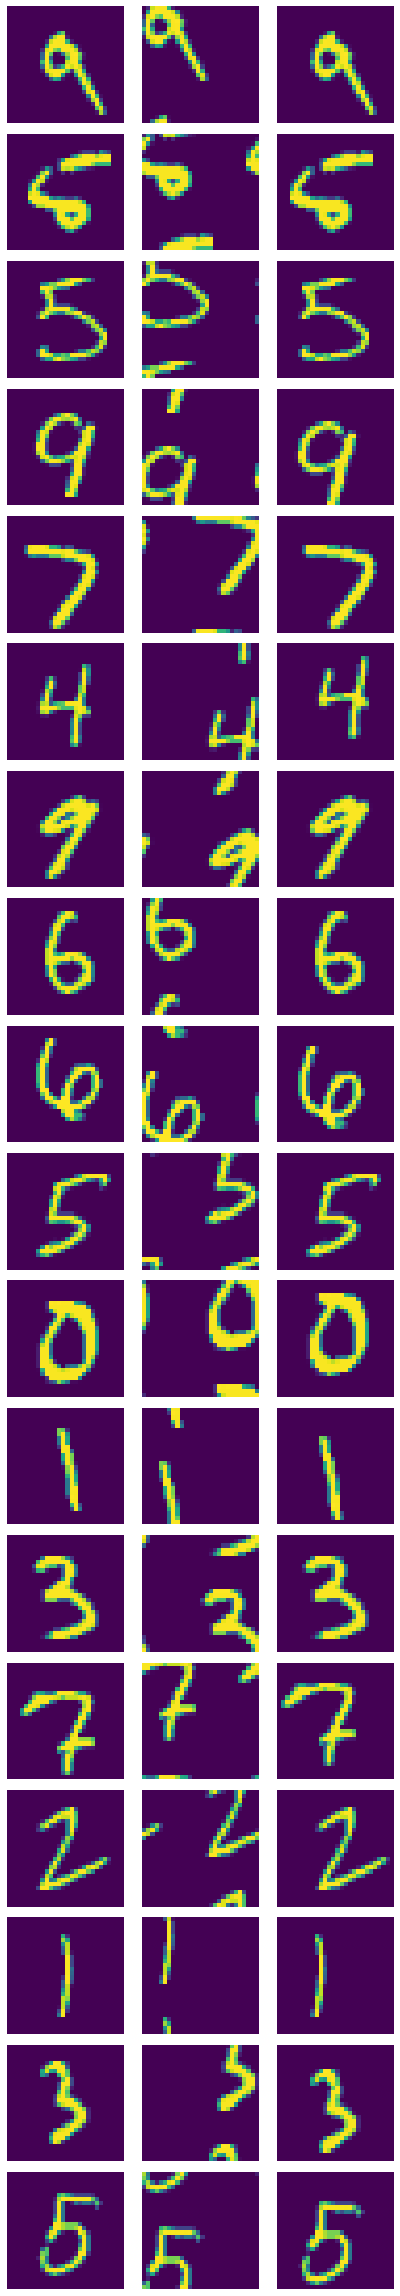

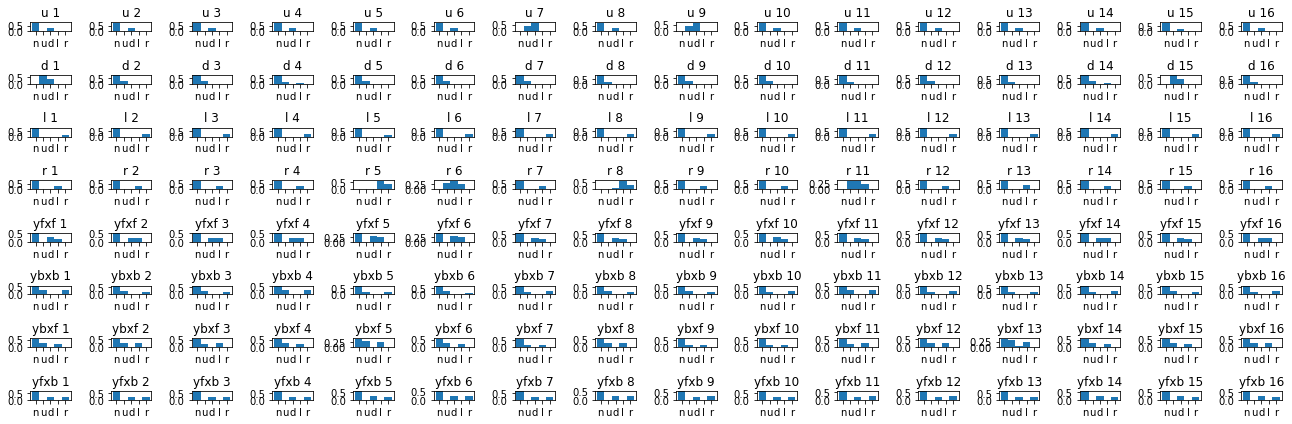

In [39]:
# INVERT
SEED = 0
data_dir = 'udlr8_diag'
outdir = f'udlr8_invert_T16'
FUNCS = getattr(shift_funcs, 'FUNCS_INVERT')
ACTIONS = getattr(shift_funcs, 'ACTIONS_INVERT')
test_labels = ['u', 'd', 'l', 'r', 'yfxf', 'ybxb', 'ybxf', 'yfxb']
# test_labels = ['u', 'd', 'l', 'r']


T = 16
# くるくるーーーーー
for (CHANNEL, WEIGHT) in [
#     [2, 0.00],
    [2, 0.05],
]:
    print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
    RESULT_PATH = Path('results/%s' % outdir) / ('channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED))
    print("RESULT_PATH", str(RESULT_PATH))

    funcs = FUNCS
    actions = [lambda x: x] + ACTIONS

    # see reward
    fig = plt.figure()
    ax = plt.subplot(111)
    ma = show_reward(ax, dir_path=str(RESULT_PATH), mono=False, n=10000, label='reward')
    plt.show()
    fig.savefig(os.path.join(RESULT_PATH, 'reward.png'))

    # load test data
    TEST_DATASET_PATH = 'data/%s/test_dataset.npz' % data_dir
    print("TEST_DATASET_PATH", TEST_DATASET_PATH)
    test_dataset_context = np.load(TEST_DATASET_PATH)
    Dx = test_dataset_context['original_dataset']
    Dx = torch.from_numpy(Dx)
    Dy = test_dataset_context['test_dataset']
    labels = test_dataset_context['test_func_labels']
    print(set(labels))
    Dy = torch.from_numpy(Dy)

    print(torch.mean((Dy - Dx)**2).item())
    # load model
    Qnet = QNet(c=CHANNEL, m=[20, 20, len(actions)])
    MODEL_PATH = RESULT_PATH / 'Qnet020000.pth'
    print('MODEL_PATH', str(MODEL_PATH))
    Qnet.load_state_dict(
        torch.load(str(MODEL_PATH))
    )
    
    METRIC_PATH = list(RESULT_PATH.glob('metrics*.npy'))
    if len(METRIC_PATH) > 0:
        result = np.load(str(METRIC_PATH[0]))
    else:
        result = agent_metrics(Dy.clone(), Dx, Qnet, actions, channel=CHANNEL)
    mse = result[:, -1].mean()
    print('MSE(test_dataset, agent_outputs) = ', mse)
    if len(METRIC_PATH) == 0 or isSave:
        np.save(str(RESULT_PATH / f'metrics{int(1000*mse):03d}.npy'), result)
    print('-' * 20)
    print()
    
    # エージェントが選択した行動から復元画像を求め、結果を保存
    SNAPSHOT_PATH = os.path.join(RESULT_PATH, 'snapshot')
    os.makedirs(SNAPSHOT_PATH, exist_ok=True)
    Dy_dest = Dy[~np.isin(labels, [0, 1, 2, 3])]
    Dx_dest = Dx[~np.isin(labels, [0, 1, 2, 3])]
    result_dest = result[~np.isin(labels, [0, 1, 2, 3])]
    fig, axes = plt.subplots(18, 3, figsize=(6, 32))
#     Dy_dest = Dy
#     Dx_dest = Dx
#     result_dest = result
#     for i in range(5):
#         for j in range(10):
#             y = Dy_dest[10 * i + j].clone()
#             y_init = y.clone()
#             x = Dx_dest[10 * i + j]
#             took_act = result_dest[10 * i + j, :-1]
#             for a in took_act:
#                 y = actions[int(a)](y)
#             x_hat = y
            
#             axes[2*i, j].imshow(x_hat)
#             axes[2*i, j].axis('off')
#             axes[2*i + 1, j].imshow(x)
#             axes[2*i + 1, j].axis('off')

    for i in range(18):
        y = Dy_dest[i].clone()
        x = Dx_dest[i]
        took_act = result_dest[i]
        for a in took_act:
            y = actions[int(a)](y)
        x_hat = y

        axes[i, 0].imshow(x)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(Dy_dest[i])
        axes[i, 1].axis('off')
        axes[i, 2].imshow(x_hat)
        axes[i, 2].axis('off')
    plt.tight_layout()
    plt.show()
    timestamp = datetime.strftime(datetime.now(), '%m%d_%H%M%S')
    restore_imgs_fname = os.path.join(SNAPSHOT_PATH, f'restore_imgs_{timestamp}.png')
    fig.savefig(restore_imgs_fname)
    
    # 選択した行動のヒストグラムを保存
    # TODO: 入力画像の4通りの変換で場合分け
    fig, axes = plt.subplots(len(test_labels), T, figsize=(18, 6))
    for i in range(len(test_labels)):
        act_hist = result[labels == i, :-1]
        for j in range(T):
            axes[i, j].set_title('%s %d' % (test_labels[i], j + 1))
            freq, _, patches = axes[i, j].hist(act_hist[j], bins=np.arange(6) - 0.5, density=True)
#             patches[freq.argsort()[::-1][0]].set_fc('r')
#             patches[freq.argsort()[::-1][1]].set_fc('r')
            axes[i, j].set_xticks(np.arange(5))
            axes[i, j].set_xticklabels(list('nudlr'))
    plt.tight_layout()
    plt.show()
    took_actions_fname = os.path.join(SNAPSHOT_PATH, f'took_actions_{timestamp}.png')
    fig.savefig(took_actions_fname)
    print()

In [47]:
# MSEだけを10種類のデータセットで求める。
# 対角追加, 上下左右のみ
SEED = 0
data_dir = 'udlr8_diag'
outdir = f'udlr8_invert_T16'
# FUNCS = getattr(shift_funcs, 'FUNCS_INVERT')
ACTIONS = getattr(shift_funcs, 'ACTIONS_INVERT')

T = 16
# くるくるーーーーー
for data_dir in ['udlr8_invert', 'udlr8_diag']:
    # load test data
    prefix = data_dir.split('_')[-1]
    TEST_DATASET_PATH = f'data/%s/test_dataset.npz' % data_dir
    print("TEST_DATASET_PATH", TEST_DATASET_PATH)
    test_dataset_context = np.load(TEST_DATASET_PATH)
    Dx = test_dataset_context['original_dataset']
    Dx = torch.from_numpy(Dx)
    Dy = test_dataset_context['test_dataset']
    labels = test_dataset_context['test_func_labels']
    Dy = torch.from_numpy(Dy)

    init_mse = torch.mean((Dy - Dx)**2, axis=(1, 2))
    # load model
    actions = [lambda x: x] + ACTIONS
    np.random.seed(1)
    an_N = np.random.choice(len(actions), (Dy.shape[0], 5))
    mse_random = []
    for n in range(Dy.shape[0]):
        an = an_N[n]
        xn = Dx[n]
        yn = Dy[n].clone()
        for a in an:
            yn = actions[a](yn)
        mse_random.append(
            torch.mean((yn - xn)**2).item()
        )
    mse_random = np.array(mse_random)
    print(prefix)
    print('init', init_mse.mean().item(), init_mse.std().item())
    print('random', mse_random.mean(), mse_random.std())

TEST_DATASET_PATH data/udlr8_invert/test_dataset.npz
invert
init 0.1795181542263965 0.05838114387604392
random 0.17944770059003992 0.06127657352033756
TEST_DATASET_PATH data/udlr8_diag/test_dataset.npz
diag
init 0.191322753940792 0.06324685453714769
random 0.18954733356479847 0.06410006674787486


In [41]:
# random
r = np.load('results/udlr8_invert_T16/random/diag/mse10_over10samples.npy')
print(r[:10].mean(axis=0), r[:10].std(axis=0))
r = np.load('results/udlr8_invert_T16/random/invert/mse10_over10samples.npy')
print(r[:10].mean(axis=0), r[:10].std(axis=0))

0.1900036712944001 0.00023485870447922307
0.17957091185415344 0.00024845802871218986


In [29]:
# w = 0.00
r = np.load('results/udlr8_invert_T16/channel02_weight000_seed00/diag/mse10_over10samples.npy')
print(r.mean(axis=0), r.std(axis=0))
r = np.load('results/udlr8_invert_T16/channel02_weight000_seed00/invert/mse10_over10samples.npy')
print(r.mean(axis=0), r.std(axis=0))

[0.19148678 0.04292901] [0.00022317 0.00030622]
[0.17951033 0.02146176] [0.00016162 0.00025973]


In [30]:
# w = 0.05
r = np.load('results/udlr8_invert_T16/channel02_weight005_seed00/diag/mse10_over10samples.npy')
print(r.mean(axis=0), r.std(axis=0))
r = np.load('results/udlr8_invert_T16/channel02_weight005_seed00/invert/mse10_over10samples.npy')
print(r.mean(axis=0), r.std(axis=0))

[0.19148678 0.04329585] [0.00022317 0.00042061]
[0.17951033 0.01595133] [0.00016162 0.00024835]


In [43]:
# MSEだけを10種類のデータセットで求める。
# 対角追加, 上下左右のみ
SEED = 0
data_dir = 'udlr8_diag'
outdir = f'udlr8_invert_T16'
# FUNCS = getattr(shift_funcs, 'FUNCS_INVERT')
ACTIONS = getattr(shift_funcs, 'ACTIONS_INVERT')

T = 16
# くるくるーーーーー
for data_dir in ['udlr8_invert', 'udlr8_diag']:
    for (CHANNEL, WEIGHT) in [
        [2, 0.00],
        [2, 0.05],
    ]:
        print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
        RESULT_PATH = Path('results/%s' % outdir) / ('channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED))
        print("RESULT_PATH", str(RESULT_PATH))

        # load test data
        prefix = data_dir.split('_')[-1]
        TEST_DATASET_PATH = f'data/%s/test_dataset.npz' % data_dir
        print("TEST_DATASET_PATH", TEST_DATASET_PATH)
        test_dataset_context = np.load(TEST_DATASET_PATH)
        Dx = test_dataset_context['original_dataset']
        Dx = torch.from_numpy(Dx)
        Dy = test_dataset_context['test_dataset']
        labels = test_dataset_context['test_func_labels']
        print(set(labels))
        Dy = torch.from_numpy(Dy)

        init_mse = torch.mean((Dy - Dx)**2).item()
        # load model
        actions = [lambda x: x] + ACTIONS
        Qnet = QNet(c=CHANNEL, m=[20, 20, len(actions)])
        MODEL_PATH = RESULT_PATH / 'Qnet020000.pth'
        print('MODEL_PATH', str(MODEL_PATH))
        Qnet.load_state_dict(
            torch.load(str(MODEL_PATH))
        )

        result = agent_metrics(Dy.clone(), Dx, Qnet, actions, channel=CHANNEL)
        print('MSE(test_dataset, agent_outputs) = ', result[:, -1].mean(), result[:, -1].std())

2 channel weight: =  0.0
RESULT_PATH results/udlr8_invert_T16/channel02_weight000_seed00
TEST_DATASET_PATH data/udlr8_invert/test_dataset.npz
{0, 1, 2, 3}
MODEL_PATH results/udlr8_invert_T16/channel02_weight000_seed00/Qnet020000.pth


100%|██████████| 10000/10000 [01:27<00:00, 113.93it/s]


MSE(test_dataset, agent_outputs) =  0.02122599409199097 0.04188772413132693
2 channel weight: =  0.05
RESULT_PATH results/udlr8_invert_T16/channel02_weight005_seed00
TEST_DATASET_PATH data/udlr8_invert/test_dataset.npz
{0, 1, 2, 3}


  0%|          | 0/10000 [00:00<?, ?it/s]

MODEL_PATH results/udlr8_invert_T16/channel02_weight005_seed00/Qnet020000.pth


100%|██████████| 10000/10000 [02:32<00:00, 65.69it/s]


MSE(test_dataset, agent_outputs) =  0.01575201993335174 0.03673177406050758
2 channel weight: =  0.0
RESULT_PATH results/udlr8_invert_T16/channel02_weight000_seed00
TEST_DATASET_PATH data/udlr8_diag/test_dataset.npz
{0, 1, 2, 3, 4, 5, 6, 7}
MODEL_PATH results/udlr8_invert_T16/channel02_weight000_seed00/Qnet020000.pth


  0%|          | 0/10000 [00:00<?, ?it/s]

MSE(test_dataset, agent_outputs) =  0.042702938671063444 0.053166144276210484
2 channel weight: =  0.05
RESULT_PATH results/udlr8_invert_T16/channel02_weight005_seed00
TEST_DATASET_PATH data/udlr8_diag/test_dataset.npz
{0, 1, 2, 3, 4, 5, 6, 7}
MODEL_PATH results/udlr8_invert_T16/channel02_weight005_seed00/Qnet020000.pth


100%|██████████| 10000/10000 [01:52<00:00, 88.96it/s]


MSE(test_dataset, agent_outputs) =  0.042769728048780195 0.05250754953588961


In [16]:
# MSEだけを10種類のデータセットで求める。
# 対角追加, 上下左右のみ
SEED = 0
data_dir = 'udlr8_diag'
outdir = f'udlr8_invert_T16'
# FUNCS = getattr(shift_funcs, 'FUNCS_INVERT')
ACTIONS = getattr(shift_funcs, 'ACTIONS_INVERT')

T = 16
# くるくるーーーーー
for (CHANNEL, WEIGHT) in [
    [2, 0.00],
#     [2, 0.05],
]:
    mse_samples = []
    for i in range(1, 11):
        print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
        RESULT_PATH = Path('results/%s' % outdir) / ('channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED))
        print("RESULT_PATH", str(RESULT_PATH))

        # load test data
        TEST_DATASET_PATH = f'data/%s/diag{i}_dataset.npz' % data_dir
        print("TEST_DATASET_PATH", TEST_DATASET_PATH)
        test_dataset_context = np.load(TEST_DATASET_PATH)
        Dx = test_dataset_context['original_dataset']
        Dx = torch.from_numpy(Dx)
        Dy = test_dataset_context['test_dataset']
        labels = test_dataset_context['test_func_labels']
        print(set(labels))
        Dy = torch.from_numpy(Dy)

        init_mse = torch.mean((Dy - Dx)**2).item()
        # load model
        actions = [lambda x: x] + ACTIONS
        Qnet = QNet(c=CHANNEL, m=[20, 20, len(actions)])
        MODEL_PATH = RESULT_PATH / 'Qnet020000.pth'
        print('MODEL_PATH', str(MODEL_PATH))
        Qnet.load_state_dict(
            torch.load(str(MODEL_PATH))
        )

        result = agent_metrics(Dy.clone(), Dx, Qnet, actions, channel=CHANNEL)
        mse = result[:, -1].mean()
        mse_samples.append([init_mse, mse])
        print('MSE(test_dataset, agent_outputs) = ', mse)
    np.save(str(RESULT_PATH / data_dir.split('_')[-1] / f'mse{i}_over10samples.npy'), np.array(mse_samples))
    print('-' * 20)
    print()

2 channel weight: =  0.0
RESULT_PATH results/udlr8_invert_T16/channel02_weight000_seed00
TEST_DATASET_PATH data/udlr8_diag/diag1_dataset.npz
{0, 1, 2, 3, 4, 5, 6, 7}
MODEL_PATH results/udlr8_invert_T16/channel02_weight000_seed00/Qnet020000.pth


100%|██████████| 10000/10000 [03:02<00:00, 54.75it/s]


MSE(test_dataset, agent_outputs) =  0.04323177989846195
2 channel weight: =  0.0
RESULT_PATH results/udlr8_invert_T16/channel02_weight000_seed00
TEST_DATASET_PATH data/udlr8_diag/diag2_dataset.npz
{0, 1, 2, 3, 4, 5, 6, 7}
MODEL_PATH results/udlr8_invert_T16/channel02_weight000_seed00/Qnet020000.pth


100%|██████████| 10000/10000 [02:05<00:00, 79.78it/s]


MSE(test_dataset, agent_outputs) =  0.042976814620490036
2 channel weight: =  0.0
RESULT_PATH results/udlr8_invert_T16/channel02_weight000_seed00
TEST_DATASET_PATH data/udlr8_diag/diag3_dataset.npz
{0, 1, 2, 3, 4, 5, 6, 7}


  0%|          | 0/10000 [00:00<?, ?it/s]

MODEL_PATH results/udlr8_invert_T16/channel02_weight000_seed00/Qnet020000.pth


100%|██████████| 10000/10000 [02:00<00:00, 83.09it/s]


MSE(test_dataset, agent_outputs) =  0.042702938671063444
2 channel weight: =  0.0
RESULT_PATH results/udlr8_invert_T16/channel02_weight000_seed00
TEST_DATASET_PATH data/udlr8_diag/diag4_dataset.npz
{0, 1, 2, 3, 4, 5, 6, 7}
MODEL_PATH results/udlr8_invert_T16/channel02_weight000_seed00/Qnet020000.pth


100%|██████████| 10000/10000 [02:02<00:00, 81.38it/s]


MSE(test_dataset, agent_outputs) =  0.04280175504736371
2 channel weight: =  0.0
RESULT_PATH results/udlr8_invert_T16/channel02_weight000_seed00
TEST_DATASET_PATH data/udlr8_diag/diag5_dataset.npz
{0, 1, 2, 3, 4, 5, 6, 7}
MODEL_PATH results/udlr8_invert_T16/channel02_weight000_seed00/Qnet020000.pth


100%|██████████| 10000/10000 [01:19<00:00, 126.06it/s]


MSE(test_dataset, agent_outputs) =  0.04283386942318758
2 channel weight: =  0.0
RESULT_PATH results/udlr8_invert_T16/channel02_weight000_seed00
TEST_DATASET_PATH data/udlr8_diag/diag6_dataset.npz
{0, 1, 2, 3, 4, 5, 6, 7}
MODEL_PATH results/udlr8_invert_T16/channel02_weight000_seed00/Qnet020000.pth


100%|██████████| 10000/10000 [01:34<00:00, 105.64it/s]


MSE(test_dataset, agent_outputs) =  0.04265564997154229
2 channel weight: =  0.0
RESULT_PATH results/udlr8_invert_T16/channel02_weight000_seed00
TEST_DATASET_PATH data/udlr8_diag/diag7_dataset.npz
{0, 1, 2, 3, 4, 5, 6, 7}
MODEL_PATH results/udlr8_invert_T16/channel02_weight000_seed00/Qnet020000.pth


100%|██████████| 10000/10000 [02:54<00:00, 57.38it/s]


MSE(test_dataset, agent_outputs) =  0.042615306607311776
2 channel weight: =  0.0
RESULT_PATH results/udlr8_invert_T16/channel02_weight000_seed00
TEST_DATASET_PATH data/udlr8_diag/diag8_dataset.npz
{0, 1, 2, 3, 4, 5, 6, 7}
MODEL_PATH results/udlr8_invert_T16/channel02_weight000_seed00/Qnet020000.pth


100%|██████████| 10000/10000 [01:55<00:00, 86.50it/s]


MSE(test_dataset, agent_outputs) =  0.04276381002980016
2 channel weight: =  0.0
RESULT_PATH results/udlr8_invert_T16/channel02_weight000_seed00
TEST_DATASET_PATH data/udlr8_diag/diag9_dataset.npz
{0, 1, 2, 3, 4, 5, 6, 7}
MODEL_PATH results/udlr8_invert_T16/channel02_weight000_seed00/Qnet020000.pth


100%|██████████| 10000/10000 [01:11<00:00, 139.19it/s]


MSE(test_dataset, agent_outputs) =  0.043674687419057556
2 channel weight: =  0.0
RESULT_PATH results/udlr8_invert_T16/channel02_weight000_seed00
TEST_DATASET_PATH data/udlr8_diag/diag10_dataset.npz
{0, 1, 2, 3, 4, 5, 6, 7}
MODEL_PATH results/udlr8_invert_T16/channel02_weight000_seed00/Qnet020000.pth


100%|██████████| 10000/10000 [01:56<00:00, 85.59it/s]


MSE(test_dataset, agent_outputs) =  0.0430334703372428
--------------------



2 channel weight: =  0.05
RESULT_PATH results/udlr8_invert_prod_reward3/channel02_weight005_seed00


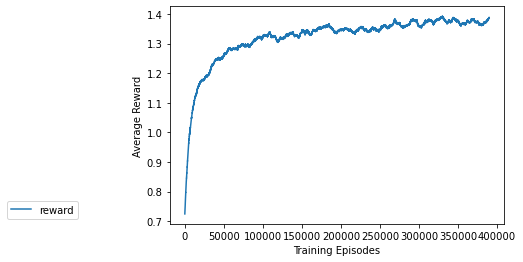

TEST_DATASET_PATH data/udlr8_diag/test_dataset.npz
{0, 1, 2, 3, 4, 5, 6, 7}


  0%|          | 0/10000 [00:00<?, ?it/s]

0.19132275394080483
MODEL_PATH results/udlr8_invert_prod_reward3/channel02_weight005_seed00/Qnet020000.pth


100%|██████████| 10000/10000 [01:53<00:00, 88.23it/s]


MSE(test_dataset, agent_outputs) =  0.042769728048780195


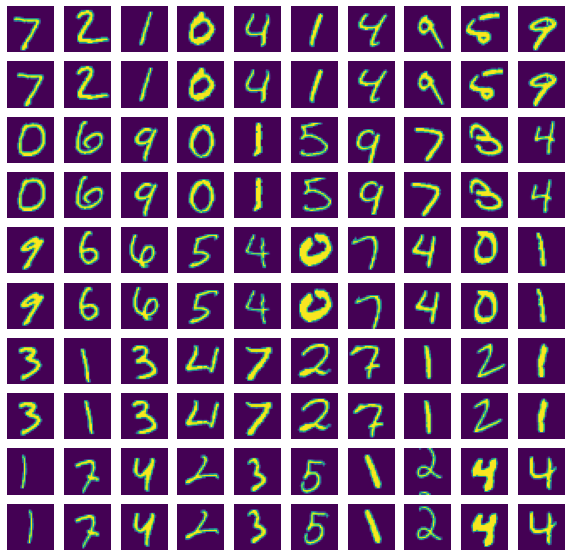

In [ ]:
# INVERT
SEED = 0
data_dir = 'udlr8_diag'
outdir = f'udlr8_invert_prod_reward3'
FUNCS = getattr(shift_funcs, 'FUNCS_INVERT')
ACTIONS = getattr(shift_funcs, 'ACTIONS_INVERT')
test_labels = ['u', 'd', 'l', 'r', 'yfxf', 'ybxb', 'ybxf', 'yfxb']
isSave = True
# test_labels = ['u', 'd', 'l', 'r']


T = 16
# くるくるーーーーー
for (CHANNEL, WEIGHT) in [
#     [2, 0.00],
    [2, 0.05],
]:
    print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
    RESULT_PATH = Path('results/%s' % outdir) / ('channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED))
    print("RESULT_PATH", str(RESULT_PATH))

    funcs = FUNCS
    actions = [lambda x: x] + ACTIONS

    # see reward
    fig = plt.figure()
    ax = plt.subplot(111)
    ma = show_reward(ax, dir_path=str(RESULT_PATH), mono=False, n=10000, label='reward')
    plt.show()
    fig.savefig(os.path.join(RESULT_PATH, 'reward.png'))

    # load test data
    TEST_DATASET_PATH = 'data/%s/test_dataset.npz' % data_dir
    print("TEST_DATASET_PATH", TEST_DATASET_PATH)
    test_dataset_context = np.load(TEST_DATASET_PATH)
    Dx = test_dataset_context['original_dataset']
    Dx = torch.from_numpy(Dx)
    Dy = test_dataset_context['test_dataset']
    labels = test_dataset_context['test_func_labels']
    print(set(labels))
    Dy = torch.from_numpy(Dy)

    print(torch.mean((Dy - Dx)**2).item())
    # load model
    Qnet = QNet(c=CHANNEL, m=[20, 20, len(actions)])
    MODEL_PATH = RESULT_PATH / 'Qnet020000.pth'
    print('MODEL_PATH', str(MODEL_PATH))
    Qnet.load_state_dict(
        torch.load(str(MODEL_PATH))
    )
    
    METRIC_PATH = list(RESULT_PATH.glob('metrics*.npy'))
    if len(METRIC_PATH) > 0:
        result = np.load(str(METRIC_PATH[0]))
    else:
        result = agent_metrics(Dy.clone(), Dx, Qnet, actions, channel=CHANNEL)
    mse = result[:, -1].mean()
    print('MSE(test_dataset, agent_outputs) = ', mse)
    if len(METRIC_PATH) == 0 or isSave:
        np.save(str(RESULT_PATH / f'metrics{int(1000*mse):03d}.npy'), result)
    print('-' * 20)
    print()
    
    # エージェントが選択した行動から復元画像を求め、結果を保存
    SNAPSHOT_PATH = os.path.join(RESULT_PATH, 'snapshot')
    os.makedirs(SNAPSHOT_PATH, exist_ok=True)
#     Dy_dest = Dy[~np.isin(labels, [0, 1, 2, 3])]
#     Dx_dest = Dx[~np.isin(labels, [0, 1, 2, 3])]
#     result_dest = result[~np.isin(labels, [0, 1, 2, 3])]
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    Dy_dest = Dy
    Dx_dest = Dx
    result_dest = result
    for i in range(5):
        for j in range(10):
            y = Dy_dest[10 * i + j].clone()
            y_init = y.clone()
            x = Dx_dest[10 * i + j]
            took_act = result_dest[10 * i + j, :-1]
            for a in took_act:
                y = actions[int(a)](y)
            x_hat = y
            
            axes[2*i, j].imshow(x_hat)
            axes[2*i, j].axis('off')
            axes[2*i + 1, j].imshow(x)
            axes[2*i + 1, j].axis('off')
    plt.show()
    timestamp = datetime.strftime(datetime.now(), '%m%d_%H%M%S')
    restore_imgs_fname = os.path.join(SNAPSHOT_PATH, f'restore_imgs_{timestamp}.png')
    fig.savefig(restore_imgs_fname)
    
    # 選択した行動のヒストグラムを保存
    # TODO: 入力画像の4通りの変換で場合分け
    fig, axes = plt.subplots(len(test_labels), T, figsize=(20, 12))
    for i in range(len(test_labels)):
        act_hist = result[labels == i, :-1]
        for j in range(T):
            axes[i, j].set_title('%s %d' % (test_labels[i], j + 1))
            freq, _, patches = axes[i, j].hist(act_hist[j], bins=np.arange(6) - 0.5, density=True)
#             patches[freq.argsort()[::-1][0]].set_fc('r')
#             patches[freq.argsort()[::-1][1]].set_fc('r')
            axes[i, j].set_xticks(np.arange(5))
            axes[i, j].set_xticklabels(list('nudlr'))
    plt.tight_layout()
    plt.show()
    took_actions_fname = os.path.join(SNAPSHOT_PATH, f'took_actions_{timestamp}.png')
    fig.savefig(took_actions_fname)
    print()

In [1]:
# 行動を増やした際の結果を確認
SEED = 0
ext = 15
data_dir = 'udlr8_invert'
outdir = f'udlr8_invert_{ext}extra'
# FUNCS = FUNCS_IRREV
# ACTIONS = ACTIONS_IRREV
FUNCS = getattr(shift_funcs, 'FUNCS_INVERT')
ACTIONS = getattr(shift_funcs, 'ACTIONS_DISASTER')[:4+ext]

T = 5
# くるくるーーーーー
for (CHANNEL, WEIGHT) in [
#     [2, 0.00],
    [2, 0.05],
]:
    print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
    RESULT_PATH = Path('results/%s' % outdir) / ('channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED))
    print("RESULT_PATH", str(RESULT_PATH))

    funcs = FUNCS
    actions = [lambda x: x] + ACTIONS

    # see reward
    fig = plt.figure()
    ax = plt.subplot(111)
    ma = show_reward(ax, dir_path=str(RESULT_PATH), mono=False, n=10000, label='reward')
    plt.show()
    fig.savefig(os.path.join(RESULT_PATH, 'reward.png'))

    # load test data
    TEST_DATASET_PATH = 'data/%s/test_dataset.npz' % data_dir
    print("TEST_DATASET_PATH", TEST_DATASET_PATH)
    test_dataset_context = np.load(TEST_DATASET_PATH)
    Dx = test_dataset_context['original_dataset']
    Dx = torch.from_numpy(Dx)
    Dy = test_dataset_context['test_dataset']
    labels = test_dataset_context['test_func_labels']
    print(set(labels))
    Dy = torch.from_numpy(Dy)

    print(torch.mean((Dy - Dx)**2).item())
    # load model
    Qnet = QNet(c=CHANNEL, m=[20, 20, len(actions)])
    MODEL_PATH = RESULT_PATH / 'Qnet020000.pth'
    print('MODEL_PATH', str(MODEL_PATH))
    Qnet.load_state_dict(
        torch.load(str(MODEL_PATH))
    )
    
    METRIC_PATH = list(RESULT_PATH.glob('metrics*.npy'))
    if len(METRIC_PATH) > 0:
        result = np.load(str(METRIC_PATH[0]))
    else:
        result = agent_metrics(Dy.clone(), Dx, Qnet, actions, channel=CHANNEL)
    mse = result[:, -1].mean()
    print('MSE(test_dataset, agent_outputs) = ', mse)
    
    # エージェントが選択した行動から復元画像を求め、結果を保存
    SNAPSHOT_PATH = os.path.join(RESULT_PATH, 'snapshot')
    os.makedirs(SNAPSHOT_PATH, exist_ok=True)
#     Dy_dest = Dy[~np.isin(labels, [0, 1, 2, 3])]
#     Dx_dest = Dx[~np.isin(labels, [0, 1, 2, 3])]
#     result_dest = result[~np.isin(labels, [0, 1, 2, 3])]
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    Dy_dest = Dy
    Dx_dest = Dx
    result_dest = result
    for i in range(5):
        for j in range(10):
            y = Dy_dest[10 * i + j].clone()
            y_init = y.clone()
            x = Dx_dest[10 * i + j]
            took_act = result_dest[10 * i + j, :-1]
            for a in took_act:
                y = actions[int(a)](y)
            x_hat = y
            
            axes[2*i, j].imshow(x_hat)
            axes[2*i, j].axis('off')
            axes[2*i + 1, j].imshow(x)
            axes[2*i + 1, j].axis('off')
    plt.show()
    timestamp = datetime.strftime(datetime.now(), '%m%d_%H%M%S')
    restore_imgs_fname = os.path.join(SNAPSHOT_PATH, f'restore_imgs_{timestamp}.png')
    fig.savefig(restore_imgs_fname)
    
    # 選択した行動のヒストグラムを保存
    # TODO: 入力画像の4通りの変換で場合分け
#     test_labels = ['u', 'd', 'l', 'r', 'yfxf', 'ybxb', 'ybxf', 'yfxb']
    test_labels = ['u', 'd', 'l', 'r']
    fig, axes = plt.subplots(len(test_labels), T, figsize=(20, 12))
    for i in range(len(test_labels)):
        act_hist = result[labels == i, :-1]
        for j in range(T):
            axes[i, j].set_title('%s %d' % (test_labels[i], j + 1))
            freq, _, patches = axes[i, j].hist(act_hist[j], bins=np.arange(6) - 0.5, density=True)
#             patches[freq.argsort()[::-1][0]].set_fc('r')
#             patches[freq.argsort()[::-1][1]].set_fc('r')
            axes[i, j].set_xticks(np.arange(5))
            axes[i, j].set_xticklabels(list('nudlr'))
    plt.tight_layout()
    plt.show()
    took_actions_fname = os.path.join(SNAPSHOT_PATH, f'took_actions_{timestamp}.png')
    fig.savefig(took_actions_fname)
    print()
    
    # 上下左右

    if len(METRIC_PATH) == 0:
        np.save(str(RESULT_PATH / f'metrics{int(1000*mse):03d}.npy'), result)
    print('-' * 20)
    print()

NameError: name 'shift_funcs' is not defined

In [88]:
### 画像を追い出した場合と右の画像に対して選択された場合を比較する。
TEST_DATASET_PATH = 'data/%s/test_dataset.npz' % data_dir
test_context = np.load(TEST_DATASET_PATH)
Dx = test_context['original_dataset']
Dy = test_context['test_dataset']
ideal_action_N = np.array(test_context['ideal_actions']) + 1
labels = test_context['test_func_labels']

RESULT_PATH = Path('results/%s' % outdir) / ('channel%02d_weight%03d_seed%02d' % (2, int(100*0.05), SEED))
METRIC_PATH = list(RESULT_PATH.glob('metrics*.npy'))
result = np.load(str(METRIC_PATH[0]))
actions = [lambda x:x] + ACTIONS_IRREV

In [90]:
### 理想的な選択肢を選べているか

N = Dx.shape[0]
count = 0
for n in range(N):
    an_expected = (ideal_action_N[n]).astype(np.int)
    an_agent = (result[n, :-1]).astype(np.int)
    an_agent = an_agent[an_agent != 0]
    if an_expected.size != an_agent.size:
        continue
    if np.allclose(an_expected, an_agent):
        count += 1
count

0

In [84]:
### 追い出した方が得か、理想的な復元の方が得か
### 「得」 == MSEが小さくなる
total = 0
count = 0
inv = [1, 0, 3, 2]
for n in range(result.shape[0]):
    a_n = result[n, :-1]
    y_n = Dy[n]
    x_n = Dx[n]
    fi_n = labels[n]
    y1 = y_n.copy()
    for a in a_n:
        y1 = actions[int(a)](y1)
    if np.sum(y1) != 0:
        continue
    total += 1
    y2 = y_n.copy()
    for _ in range(4):
        y2 = actions[inv[fi_n]](y2)
    mse1 = np.mean((y1 - x)**2)  #エージェントが追い出した画像
    mse2 = np.mean((y2 - x)**2)  #想定される変換によって作成した画像
    if mse1 < mse2:
        count += 1
print('出力が0の画像の件数:', total)
print('追い出した方が得の画像の件数:', count)

出力が0の画像の件数: 316
追い出した方が得の画像の件数: 302
